In [74]:
import numpy as np
import pandas as pd
import wrangle
import itertools
from scipy import stats
import math

#from pandas_profiling import ProfileReport


import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import seaborn as sns
import missingno as msno

from pandas.plotting import scatter_matrix

import plotly.offline as py
import plotly.graph_objs as go
import plotly.tools as tls
import plotly.figure_factory as ff
import plotly.express as px
import plotly.io as pio
from plotly.subplots import make_subplots

# pd.options.display.max_columns = 186
# pd.set_option("display.max_rows", 101)

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# pd.set_option('display.max_rows', 100)
# pd.set_option('display.max_columns', 200)

import lightgbm as lgb
import xgboost as xgb
import catboost as cat

ModuleNotFoundError: No module named 'lightgbm'

In [3]:
df = pd.read_csv('data/training_v2.csv')

In [4]:
df = wrangle.get_training_data()

---Acquiring the Data---
rows: 91713, columns: 186


---Handling Missing Values---
Filling nulls with mode for the following features:
	 * age
	 * bmi
	 * ethnicity
Handling nulls within rows
	 * Dropping patients with no recorded gender
		 - Number of patients dropped: 25
Filling nulls with 0 (aka False) for the following columns
	 * arf_apache
	 * intubated_apache
	 * cirrhosis
	 * aids
	 * diabetes_mellitus
	 * hepatic_failure
	 * immunosuppression
	 * leukemia
	 * lymphoma
	 * solid_tumor_with_metastasis
	 * hospital_death
	 * ethnicity
	 * gender
	 * age
	 * bmi


In [5]:
df.head()

encounter_id  patient_id  hospital_id  hospital_death   age    bmi  elective_surgery  ethnicity gender  height hospital_admit_source           icu_admit_source  icu_id icu_stay_type      icu_type  pre_icu_los_days  readmission_status  weight  albumin_apache  apache_2_diagnosis  apache_3j_diagnosis  apache_post_operative  arf_apache  bilirubin_apache  bun_apache  creatinine_apache  fio2_apache  gcs_eyes_apache  gcs_motor_apache  gcs_unable_apache  gcs_verbal_apache  glucose_apache  heart_rate_apache  hematocrit_apache  intubated_apache  map_apache  paco2_apache  paco2_for_ph_apache  pao2_apache  ph_apache  resprate_apache  sodium_apache  temp_apache  urineoutput_apache  ventilated_apache  wbc_apache  d1_diasbp_invasive_max  d1_diasbp_invasive_min  d1_diasbp_max  d1_diasbp_min  d1_diasbp_noninvasive_max  d1_diasbp_noninvasive_min  d1_heartrate_max  d1_heartrate_min  d1_mbp_invasive_max  d1_mbp_invasive_min  d1_mbp_max  d1_mbp_min  d1_mbp_noninvasive_max  d1_mbp_noninvasive_min  \
0         66154       25312          118               0  68.0  22.73                 0  Caucasian      M   180.3                 Floor                      Floor      92         admit         CTICU          0.541667                   0    73.9             2.3               113.0               502.01                      0         0.0               0.4        31.0               2.51          NaN              3.0               6.0                0.0                4.0           168.0              118.0               27.4               0.0        40.0           NaN                  NaN          NaN        NaN             36.0          134.0         39.3                 NaN                0.0        14.1                    46.0                    32.0           68.0           37.0                       68.0                       37.0             119.0              72.0                 66.0                 40.0        89.0        46.0                    89.0                    46.0   
1        114252       59342           81               0  77.0  27.42                 0  Caucasian      F   160.0                 Floor                      Floor      90         admit  Med-Surg ICU          0.927778                   0    70.2             NaN               108.0               203.01                      0         0.0               NaN         9.0               0.56          1.0              1.0               3.0                0.0                1.0           145.0              120.0               36.9               0.0        46.0          37.0                 37.0         51.0       7.45             33.0          145.0         35.1                 NaN                1.0        12.7                     NaN                     NaN           95.0           31.0                       95.0                       31.0             118.0              72.0                  NaN                  NaN       120.0        38.0                   120.0                    38.0   
2        119783       50777          118               0  25.0  31.95                 0  Caucasian      F   172.7  Emergency Department       Accident & Emergency      93         admit  Med-Surg ICU          0.000694                   0    95.3             NaN               122.0               703.03                      0         0.0               NaN         NaN                NaN          NaN              3.0               6.0                0.0                5.0             NaN              102.0                NaN               0.0        68.0           NaN                  NaN          NaN        NaN             37.0            NaN         36.7                 NaN                0.0         NaN                     NaN                     NaN           88.0           48.0                       88.0                       48.0              96.0              68.0                  NaN                  NaN       102.0        68.0                   102.0                    68.0   
3         79267    

In [6]:
df.apache_2_bodysystem.value_counts()

Cardiovascular         38806
Neurologic             11895
Respiratory            11606
Gastrointestinal        9025
Metabolic               7647
Trauma                  3836
Undefined diagnoses     3768
Renal/Genitourinary     2460
Haematologic             638
Undefined Diagnoses      346
Name: apache_2_bodysystem, dtype: int64

In [7]:
df.shape

(91688, 186)

In [8]:
working_df = df[['hospital_id', 'hospital_death', 'bmi', 'age', 'gender', 'ethnicity', 'solid_tumor_with_metastasis', 'lymphoma', 'leukemia', 'immunosuppression', 'hepatic_failure', 'diabetes_mellitus', 'aids', 'cirrhosis', 'intubated_apache', 'arf_apache']].copy()

In [9]:
working_df.head()

hospital_id  hospital_death    bmi   age gender  ethnicity  solid_tumor_with_metastasis  lymphoma  leukemia  immunosuppression  hepatic_failure  diabetes_mellitus  aids  cirrhosis  intubated_apache  arf_apache
0          118               0  22.73  68.0      M  Caucasian                          0.0       0.0       0.0                0.0              0.0                1.0   0.0        0.0               0.0         0.0
1           81               0  27.42  77.0      F  Caucasian                          0.0       0.0       0.0                0.0              0.0                1.0   0.0        0.0               0.0         0.0
2          118               0  31.95  25.0      F  Caucasian                          0.0       0.0       0.0                0.0              0.0                0.0   0.0        0.0               0.0         0.0
3          118               0  22.64  81.0      F  Caucasian                          0.0       0.0       0.0                0.0              0.0                0.0   0.0        0.0               1.0         0.0
4           33               0  14.00  19.0      M  Caucasian                          0.0       0.0       0.0                0.0              0.0                0.0   0.0        0.0               0.0         0.0

In [10]:
working_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 91688 entries, 0 to 91712
Data columns (total 16 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   hospital_id                  91688 non-null  int64  
 1   hospital_death               91688 non-null  int64  
 2   bmi                          91688 non-null  float64
 3   age                          91688 non-null  float64
 4   gender                       91688 non-null  object 
 5   ethnicity                    91688 non-null  object 
 6   solid_tumor_with_metastasis  91688 non-null  float64
 7   lymphoma                     91688 non-null  float64
 8   leukemia                     91688 non-null  float64
 9   immunosuppression            91688 non-null  float64
 10  hepatic_failure              91688 non-null  float64
 11  diabetes_mellitus            91688 non-null  float64
 12  aids                         91688 non-null  float64
 13  cirrhosis       

In [11]:
working_df.isna().sum()

hospital_id                    0
hospital_death                 0
bmi                            0
age                            0
gender                         0
ethnicity                      0
solid_tumor_with_metastasis    0
lymphoma                       0
leukemia                       0
immunosuppression              0
hepatic_failure                0
diabetes_mellitus              0
aids                           0
cirrhosis                      0
intubated_apache               0
arf_apache                     0
dtype: int64

In [12]:
# sns.heatmap(working_df.drop(['hospital_id'],axis=1), annot=True, annot_kws={"size": 7})
# sns.heatmap(working_df,  nominal_columns=['hospital_id', 'gender', 'ethnicity'])

In [13]:
# working_df = working_df.astype({'patient_id': 'object'})

In [14]:
working_df = working_df.astype({'hospital_id': 'object'})

In [15]:
working_df = working_df.astype({'gender': 'object'})

In [16]:
working_df = working_df.astype({'ethnicity': 'object'})

In [17]:
working_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 91688 entries, 0 to 91712
Data columns (total 16 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   hospital_id                  91688 non-null  object 
 1   hospital_death               91688 non-null  int64  
 2   bmi                          91688 non-null  float64
 3   age                          91688 non-null  float64
 4   gender                       91688 non-null  object 
 5   ethnicity                    91688 non-null  object 
 6   solid_tumor_with_metastasis  91688 non-null  float64
 7   lymphoma                     91688 non-null  float64
 8   leukemia                     91688 non-null  float64
 9   immunosuppression            91688 non-null  float64
 10  hepatic_failure              91688 non-null  float64
 11  diabetes_mellitus            91688 non-null  float64
 12  aids                         91688 non-null  float64
 13  cirrhosis       

In [18]:
working_df.shape

(91688, 16)

In [109]:
# def cramers_corrected_stat(confusion_matrix):
#     """
#     Calculates the corrected Cramer's V statistic
    
#     Args:
#         confusion_matrix: The confusion matrix of the variables to calculate the statistic on
    
#     Returns:
#         The corrected Cramer'v V statistic
#     """
    
#     chi2, _, _, _ = stats.chi2_contingency(confusion_matrix)
#     n = confusion_matrix.sum().sum()
#     phi2 = chi2/n
#     r, k = confusion_matrix.shape
#     phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
#     rcorr = r - ((r-1)**2)/(n-1)
#     kcorr = k - ((k-1)**2)/(n-1)
    
#     return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

# cols = working_df.columns.values.tolist()
# corrM = np.zeros((len(cols),len(cols)))

# # Calculate s of every combination of variables
# for col1, col2 in itertools.combinations(cols, 2):

#     a, b = working_df[col1], working_df[col2]
    
#     idx1, idx2 = cols.index(col1), cols.index(col2)
#     dfObserved = pd.crosstab(a,b) 
#     corrM[idx1, idx2] = cramers_corrected_stat(dfObserved.values)
#     corrM[idx2, idx1] = corrM[idx1, idx2]

# corr = pd.DataFrame(corrM, index=cols, columns=cols)

# # Mask to get lower triangle
# mask = np.zeros_like(corr, dtype=np.bool)
# mask[np.triu_indices_from(mask)] = True

# cmap = sns.cubehelix_palette(light=1, as_cmap=True)

# # Draw the heatmap with the mask 
# fig = plt.figure(figsize=(20, 20))

# sns.heatmap(corr, mask=mask, cmap='Blues', square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)
# plt.title('Cramer’s V calculated for the hospital death')
# plt.show()

In [19]:
# Set alpha value
alpha = 0.05

for col in df.columns:

    a, b = df[col], df["hospital_death"]

    observed = pd.crosstab(a, b) 
    chi2, p, degf, expected = stats.chi2_contingency(observed)

    if p < alpha:
        # Reject the null hypothesis
        print("({} and hospital_death) are  dependent of each other. (p = {})".format(col, p))
    else:
         # Failed to reject the null hypothesis
        print("({} and hospital_death) are  independent of each other. (p = {})".format(col, p))

(encounter_id and hospital_death) are  independent of each other. (p = 0.4984472990249586)
(patient_id and hospital_death) are  independent of each other. (p = 0.49844729902497215)
(hospital_id and hospital_death) are  dependent of each other. (p = 4.1849665138946445e-147)
(hospital_death and hospital_death) are  dependent of each other. (p = 0.0)
(age and hospital_death) are  dependent of each other. (p = 1.196359515342852e-226)
(bmi and hospital_death) are  independent of each other. (p = 0.3628499081984528)
(elective_surgery and hospital_death) are  dependent of each other. (p = 3.40514323118526e-176)
(ethnicity and hospital_death) are  dependent of each other. (p = 0.002477606556537611)
(gender and hospital_death) are  dependent of each other. (p = 0.03441709366041668)
(height and hospital_death) are  dependent of each other. (p = 0.002402442108060369)
(hospital_admit_source and hospital_death) are  dependent of each other. (p = 8.351664221020479e-198)
(icu_admit_source and hospita

(h1_sysbp_noninvasive_max and hospital_death) are  dependent of each other. (p = 3.3759991218927526e-181)
(h1_sysbp_noninvasive_min and hospital_death) are  dependent of each other. (p = 0.0)
(h1_temp_max and hospital_death) are  dependent of each other. (p = 0.0)
(h1_temp_min and hospital_death) are  dependent of each other. (p = 0.0)
(d1_albumin_max and hospital_death) are  dependent of each other. (p = 1.960127676514452e-281)
(d1_albumin_min and hospital_death) are  dependent of each other. (p = 0.0)
(d1_bilirubin_max and hospital_death) are  dependent of each other. (p = 2.9501942675898763e-175)
(d1_bilirubin_min and hospital_death) are  dependent of each other. (p = 8.647147243647446e-153)
(d1_bun_max and hospital_death) are  dependent of each other. (p = 0.0)
(d1_bun_min and hospital_death) are  dependent of each other. (p = 0.0)
(d1_calcium_max and hospital_death) are  dependent of each other. (p = 5.990068466168162e-270)
(d1_calcium_min and hospital_death) are  dependent of eac

(apache_2_bodysystem and hospital_death) are  dependent of each other. (p = 6.011197317797345e-235)


In [104]:
# def df_to_plotly(df):
#     return {'z': df.values.tolist(),
#             'x': df.columns.tolist(),
#             'y': df.index.tolist()}

In [108]:
# fig = go.Figure(data=go.Heatmap(df_to_plotly(df)))
# fig.show()

In [106]:
df.head()

encounter_id  patient_id  hospital_id  hospital_death   age    bmi  elective_surgery  ethnicity gender  height hospital_admit_source           icu_admit_source  icu_id icu_stay_type      icu_type  pre_icu_los_days  readmission_status  weight  albumin_apache  apache_2_diagnosis  apache_3j_diagnosis  apache_post_operative  arf_apache  bilirubin_apache  bun_apache  creatinine_apache  fio2_apache  gcs_eyes_apache  gcs_motor_apache  gcs_unable_apache  gcs_verbal_apache  glucose_apache  heart_rate_apache  hematocrit_apache  intubated_apache  map_apache  paco2_apache  paco2_for_ph_apache  pao2_apache  ph_apache  resprate_apache  sodium_apache  temp_apache  urineoutput_apache  ventilated_apache  wbc_apache  d1_diasbp_invasive_max  d1_diasbp_invasive_min  d1_diasbp_max  d1_diasbp_min  d1_diasbp_noninvasive_max  d1_diasbp_noninvasive_min  d1_heartrate_max  d1_heartrate_min  d1_mbp_invasive_max  d1_mbp_invasive_min  d1_mbp_max  d1_mbp_min  d1_mbp_noninvasive_max  d1_mbp_noninvasive_min  \
0         66154       25312          118               0  68.0  22.73                 0  Caucasian      M   180.3                 Floor                      Floor      92         admit         CTICU          0.541667                   0    73.9             2.3               113.0               502.01                      0         0.0               0.4        31.0               2.51          NaN              3.0               6.0                0.0                4.0           168.0              118.0               27.4               0.0        40.0           NaN                  NaN          NaN        NaN             36.0          134.0         39.3                 NaN                0.0        14.1                    46.0                    32.0           68.0           37.0                       68.0                       37.0             119.0              72.0                 66.0                 40.0        89.0        46.0                    89.0                    46.0   
1        114252       59342           81               0  77.0  27.42                 0  Caucasian      F   160.0                 Floor                      Floor      90         admit  Med-Surg ICU          0.927778                   0    70.2             NaN               108.0               203.01                      0         0.0               NaN         9.0               0.56          1.0              1.0               3.0                0.0                1.0           145.0              120.0               36.9               0.0        46.0          37.0                 37.0         51.0       7.45             33.0          145.0         35.1                 NaN                1.0        12.7                     NaN                     NaN           95.0           31.0                       95.0                       31.0             118.0              72.0                  NaN                  NaN       120.0        38.0                   120.0                    38.0   
2        119783       50777          118               0  25.0  31.95                 0  Caucasian      F   172.7  Emergency Department       Accident & Emergency      93         admit  Med-Surg ICU          0.000694                   0    95.3             NaN               122.0               703.03                      0         0.0               NaN         NaN                NaN          NaN              3.0               6.0                0.0                5.0             NaN              102.0                NaN               0.0        68.0           NaN                  NaN          NaN        NaN             37.0            NaN         36.7                 NaN                0.0         NaN                     NaN                     NaN           88.0           48.0                       88.0                       48.0              96.0              68.0                  NaN                  NaN       102.0        68.0                   102.0                    68.0   
3         79267    

In [20]:
# d = dict.fromkeys(['columns', 'nulls', 'ratio', 'val1', 'val'])
list = []
for c in df.columns:
    list1 = []
    val = df[df[c].notna()].hospital_death.value_counts()[1]/df[df[c].notna()].hospital_death.value_counts()[0]
    if df[c].isna().sum() > 0:
        val1 = df[df[c].isna()].hospital_death.value_counts()[1]/df[df[c].isna()].hospital_death.value_counts()[0]
        if abs(val1-val) > 0.05:
            list1.append(c)
            list1.append(df[c].isna().sum())
            list1.append(val1/val)
            list1.append(val1)
            list1.append(val)
            list1.append(df[df[c].isna()].hospital_death.value_counts()[1])


            list.append(list1)

# print(list)
#             print(f'{c}: total_nulls: {df[c].isna().sum()} , ratio: {val1/val},  val1:{val1}, val:{val}')

In [21]:
df2 = pd.DataFrame.from_records(list)

In [22]:
df2.head()

0      1         2         3         4     5
0            height   1328  1.743245  0.162872  0.093430   186
1    albumin_apache  54361  0.592213  0.074158  0.125222  3753
2       fio2_apache  70848  0.291086  0.063002  0.216437  4199
3   gcs_eyes_apache   1898  2.257496  0.208148  0.092203   327
4  gcs_motor_apache   1898  2.257496  0.208148  0.092203   327

In [23]:
df2.columns = ['column', 'num_nulls', 'val1_val_ratio', 'null_deathrate', 'not_null_deathrate', 'null_deaths']

In [24]:
df2.sort_values(by=['not_null_deathrate'], ascending = False)

column  num_nulls  val1_val_ratio  null_deathrate  not_null_deathrate  null_deaths
44          h1_lactate_min      84346        0.386880        0.084724            0.218994         6588
43          h1_lactate_max      84346        0.386880        0.084724            0.218994         6588
8              pao2_apache      70848        0.291086        0.063002            0.216437         4199
2              fio2_apache      70848        0.291086        0.063002            0.216437         4199
9                ph_apache      70848        0.291086        0.063002            0.216437         4199
6             paco2_apache      70848        0.291086        0.063002            0.216437         4199
7      paco2_for_ph_apache      70848        0.291086        0.063002            0.216437         4199
51    d1_pao2fio2ratio_max      65989        0.266891        0.055604            0.208341         3476
52    d1_pao2fio2ratio_min      65989        0.266891        0.055604            0.208341         3476
35          d1_lactate_max      68378        0.289880        0.060338            0.208148         3891
36          d1_lactate_min      68378        0.289880        0.060338            0.208148         3891
47      d1_arterial_ph_max      60108        0.249896        0.048456            0.193906         2778
48      d1_arterial_ph_min      60108        0.249896        0.048456            0.193906         2778
50     d1_arterial_po2_min      59247        0.241366        0.046730            0.193605         2645
49     d1_arterial_po2_max      59247        0.241366        0.046730            0.193605         2645
45    d1_arterial_pco2_max      59256        0.241849        0.046796            0.193494         2649
46    d1_arterial_pco2_min      59256        0.241849        0.046796            0.193494         2649
60    h1_pao2fio2ratio_min      80172        0.495623        0.084299            0.170087         6233
59    h1_pao2fio2ratio_max      80172        0.495623        0.084299            0.170087         6233
53    h1_arterial_pco2_max      75939        0.479155        0.080321            0.167630         5646
54    h1_arterial_pco2_min      75939        0.479155        0.080321            0.167630         5646
55      h1_arterial_ph_max      76404        0.482173        0.080817            0.167609         5713
56      h1_arterial_ph_min      76404        0.482173        0.080817            0.167609         5713
58     h1_arterial_po2_min      75925        0.479408        0.080322            0.167543         5645
57     h1_arterial_po2_max      75925        0.479408        0.080322            0.167543         5645
40        h1_bilirubin_min      84596        0.531733        0.088710            0.166831         6893
39        h1_bilirubin_max      84596        0.531733        0.088710            0.166831         6893
37          h1_albumin_max      83801        0.529911        0.088070            0.166198         6783
38          h1_albumin_min      83801        0.529911        0.088070            0.166198         6783
17     d1_mbp_invasive_max      67757        0.538229        0.077732            0.144422         4887
18     d1_mbp_invasive_min      67757        0.538229        0.077732            0.144422         4887
24   d1_sysbp_invasive_min      67939        0.540053        0.077935            0.144310         4912
23   d1_sysbp_invasive_max      67939        0.540053        0.077935            0.144310         4912
11  d1_diasbp_invasive_max      67964        0.540814        0.077989            0.144208         4917
12  d1_diasbp_invasive_min      67964        0.540814        0.077989            0.144208         4917
41              h1_inr_max      57922        0.519366        0.071063            0.136826         3843
34              d1_inr_min      57922        0.519366        0.071063            0.136826         3843
33              d1_inr_max      57922        0.519366        0.071063            0.136826         3843
42 

In [25]:
df2 = df2.drop(df2.index[[43, 6, 52, 36, 48, 50, 46, 59, 54, 55, 57, 40, 38, 18, 23, 12, 34, 33, 42, 32, 30, 15, 20, 14, 26, 22, 28, 5, 4]])

In [26]:
df2.sort_values(by=['not_null_deathrate'], ascending = False)

column  num_nulls  val1_val_ratio  null_deathrate  not_null_deathrate  null_deaths
44          h1_lactate_min      84346        0.386880        0.084724            0.218994         6588
2              fio2_apache      70848        0.291086        0.063002            0.216437         4199
7      paco2_for_ph_apache      70848        0.291086        0.063002            0.216437         4199
8              pao2_apache      70848        0.291086        0.063002            0.216437         4199
9                ph_apache      70848        0.291086        0.063002            0.216437         4199
51    d1_pao2fio2ratio_max      65989        0.266891        0.055604            0.208341         3476
35          d1_lactate_max      68378        0.289880        0.060338            0.208148         3891
47      d1_arterial_ph_max      60108        0.249896        0.048456            0.193906         2778
49     d1_arterial_po2_max      59247        0.241366        0.046730            0.193605         2645
45    d1_arterial_pco2_max      59256        0.241849        0.046796            0.193494         2649
60    h1_pao2fio2ratio_min      80172        0.495623        0.084299            0.170087         6233
53    h1_arterial_pco2_max      75939        0.479155        0.080321            0.167630         5646
56      h1_arterial_ph_min      76404        0.482173        0.080817            0.167609         5713
58     h1_arterial_po2_min      75925        0.479408        0.080322            0.167543         5645
39        h1_bilirubin_max      84596        0.531733        0.088710            0.166831         6893
37          h1_albumin_max      83801        0.529911        0.088070            0.166198         6783
17     d1_mbp_invasive_max      67757        0.538229        0.077732            0.144422         4887
24   d1_sysbp_invasive_min      67939        0.540053        0.077935            0.144310         4912
11  d1_diasbp_invasive_max      67964        0.540814        0.077989            0.144208         4917
41              h1_inr_max      57922        0.519366        0.071063            0.136826         3843
31        d1_bilirubin_max      53656        0.585614        0.073421            0.125374         3670
1           albumin_apache      54361        0.592213        0.074158            0.125222         3753
29          d1_albumin_max      49079        0.563246        0.069865            0.124040         3205
16        d1_heartrate_min        144        1.710798        0.161290            0.094278           20
19              d1_mbp_max        219        1.619526        0.152632            0.094245           29
13           d1_diasbp_max        164        2.475483        0.233083            0.094156           31
25            d1_sysbp_max        158        2.592621        0.244094            0.094150           31
21             d1_spo2_max        331        1.891008        0.177936            0.094096           50
0                   height       1328        1.743245        0.162872            0.093430          186
27             d1_temp_max       2320        1.705191        0.158263            0.092812          317
3          gcs_eyes_apache       1898        2.257496        0.208148            0.092203          327
10             temp_apache       4103        1.718537        0.157405            0.091592          558

In [27]:
df2 = df2.reset_index()
df2 = df2.drop(columns=['index'])

In [28]:
df2

column  num_nulls  val1_val_ratio  null_deathrate  not_null_deathrate  null_deaths
0                   height       1328        1.743245        0.162872            0.093430          186
1           albumin_apache      54361        0.592213        0.074158            0.125222         3753
2              fio2_apache      70848        0.291086        0.063002            0.216437         4199
3          gcs_eyes_apache       1898        2.257496        0.208148            0.092203          327
4      paco2_for_ph_apache      70848        0.291086        0.063002            0.216437         4199
5              pao2_apache      70848        0.291086        0.063002            0.216437         4199
6                ph_apache      70848        0.291086        0.063002            0.216437         4199
7              temp_apache       4103        1.718537        0.157405            0.091592          558
8   d1_diasbp_invasive_max      67964        0.540814        0.077989            0.144208         4917
9            d1_diasbp_max        164        2.475483        0.233083            0.094156           31
10        d1_heartrate_min        144        1.710798        0.161290            0.094278           20
11     d1_mbp_invasive_max      67757        0.538229        0.077732            0.144422         4887
12              d1_mbp_max        219        1.619526        0.152632            0.094245           29
13             d1_spo2_max        331        1.891008        0.177936            0.094096           50
14   d1_sysbp_invasive_min      67939        0.540053        0.077935            0.144310         4912
15            d1_sysbp_max        158        2.592621        0.244094            0.094150           31
16             d1_temp_max       2320        1.705191        0.158263            0.092812          317
17          d1_albumin_max      49079        0.563246        0.069865            0.124040         3205
18        d1_bilirubin_max      53656        0.585614        0.073421            0.125374         3670
19          d1_lactate_max      68378        0.289880        0.060338            0.208148         3891
20          h1_albumin_max      83801        0.529911        0.088070            0.166198         6783
21        h1_bilirubin_max      84596        0.531733        0.088710            0.166831         6893
22              h1_inr_max      57922        0.519366        0.071063            0.136826         3843
23          h1_lactate_min      84346        0.386880        0.084724            0.218994         6588
24    d1_arterial_pco2_max      59256        0.241849        0.046796            0.193494         2649
25      d1_arterial_ph_max      60108        0.249896        0.048456            0.193906         2778
26     d1_arterial_po2_max      59247        0.241366        0.046730            0.193605         2645
27    d1_pao2fio2ratio_max      65989        0.266891        0.055604            0.208341         3476
28    h1_arterial_pco2_max      75939        0.479155        0.080321            0.167630         5646
29      h1_arterial_ph_min      76404        0.482173        0.080817            0.167609         5713
30     h1_arterial_po2_min      75925        0.479408        0.080322            0.167543         5645
31    h1_pao2fio2ratio_min      80172        0.495623        0.084299            0.170087         6233

In [29]:
df2.sort_values(by=['val1_val_ratio'], ascending = False)

column  num_nulls  val1_val_ratio  null_deathrate  not_null_deathrate  null_deaths
15            d1_sysbp_max        158        2.592621        0.244094            0.094150           31
9            d1_diasbp_max        164        2.475483        0.233083            0.094156           31
3          gcs_eyes_apache       1898        2.257496        0.208148            0.092203          327
13             d1_spo2_max        331        1.891008        0.177936            0.094096           50
0                   height       1328        1.743245        0.162872            0.093430          186
7              temp_apache       4103        1.718537        0.157405            0.091592          558
10        d1_heartrate_min        144        1.710798        0.161290            0.094278           20
16             d1_temp_max       2320        1.705191        0.158263            0.092812          317
12              d1_mbp_max        219        1.619526        0.152632            0.094245           29
1           albumin_apache      54361        0.592213        0.074158            0.125222         3753
18        d1_bilirubin_max      53656        0.585614        0.073421            0.125374         3670
17          d1_albumin_max      49079        0.563246        0.069865            0.124040         3205
8   d1_diasbp_invasive_max      67964        0.540814        0.077989            0.144208         4917
14   d1_sysbp_invasive_min      67939        0.540053        0.077935            0.144310         4912
11     d1_mbp_invasive_max      67757        0.538229        0.077732            0.144422         4887
21        h1_bilirubin_max      84596        0.531733        0.088710            0.166831         6893
20          h1_albumin_max      83801        0.529911        0.088070            0.166198         6783
22              h1_inr_max      57922        0.519366        0.071063            0.136826         3843
31    h1_pao2fio2ratio_min      80172        0.495623        0.084299            0.170087         6233
29      h1_arterial_ph_min      76404        0.482173        0.080817            0.167609         5713
30     h1_arterial_po2_min      75925        0.479408        0.080322            0.167543         5645
28    h1_arterial_pco2_max      75939        0.479155        0.080321            0.167630         5646
23          h1_lactate_min      84346        0.386880        0.084724            0.218994         6588
2              fio2_apache      70848        0.291086        0.063002            0.216437         4199
4      paco2_for_ph_apache      70848        0.291086        0.063002            0.216437         4199
6                ph_apache      70848        0.291086        0.063002            0.216437         4199
5              pao2_apache      70848        0.291086        0.063002            0.216437         4199
19          d1_lactate_max      68378        0.289880        0.060338            0.208148         3891
27    d1_pao2fio2ratio_max      65989        0.266891        0.055604            0.208341         3476
25      d1_arterial_ph_max      60108        0.249896        0.048456            0.193906         2778
24    d1_arterial_pco2_max      59256        0.241849        0.046796            0.193494         2649
26     d1_arterial_po2_max      59247        0.241366        0.046730            0.193605         2645

In [30]:
df2['null_death_ratio'] = df2.null_deaths/df2.num_nulls

In [31]:
df2 = df2.sort_values(by=['val1_val_ratio'], ascending = False)

In [32]:
df2 = df2.head(9)

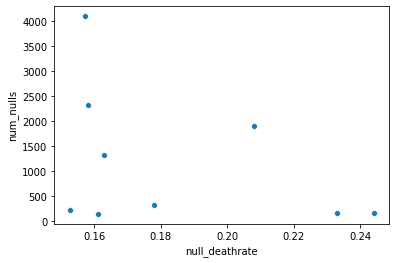

In [33]:
ax = sns.scatterplot(x="null_deathrate", y="num_nulls", data=df2)

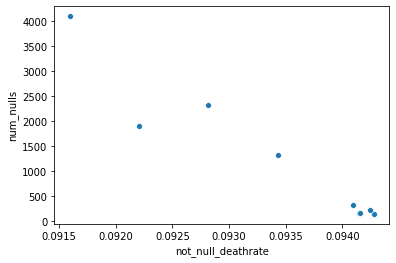

In [34]:
ax = sns.scatterplot(x="not_null_deathrate", y="num_nulls", data=df2)

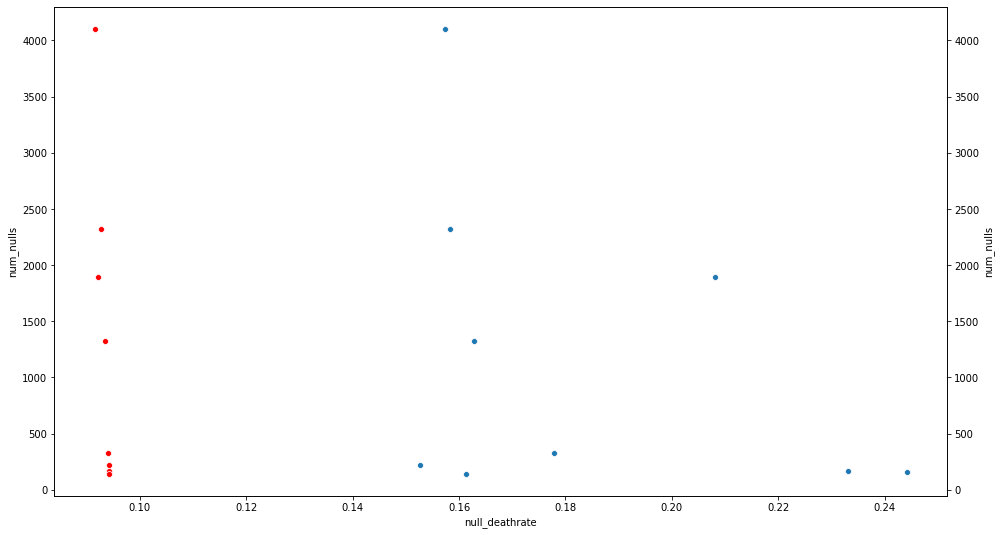

In [35]:
a4_dims = (16, 9)
fig, ax = plt.subplots(figsize=a4_dims)
sns.scatterplot(x='null_deathrate', y='num_nulls', data=df2, ax=ax)
ax2 = ax.twinx()
sns.scatterplot(x='not_null_deathrate', y='num_nulls', data=df2, ax=ax2, color='r')
plt.show()

In [36]:
df2_melt = df2.melt()

In [38]:
df2_melt.drop(df2_melt.index[[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62]])

#ax = sns.scatterplot(x="variable", y="num_nulls", data=df2)

variable      value
27      null_deathrate   0.244094
28      null_deathrate   0.233083
29      null_deathrate   0.208148
30      null_deathrate   0.177936
31      null_deathrate   0.162872
32      null_deathrate   0.157405
33      null_deathrate    0.16129
34      null_deathrate   0.158263
35      null_deathrate   0.152632
36  not_null_deathrate  0.0941497
37  not_null_deathrate  0.0941565
38  not_null_deathrate  0.0922029
39  not_null_deathrate  0.0940958
40  not_null_deathrate  0.0934305
41  not_null_deathrate  0.0915923
42  not_null_deathrate  0.0942778
43  not_null_deathrate  0.0928122
44  not_null_deathrate  0.0942446

In [40]:
def in_range (lowerlimit, upperlimit, value):
    return lowerlimit <= value <= upperlimit

def calculate_scores(h1max,h1min,d1max,d1min,value_ranges):
    max_score=0
    min_score=0
    hd_value=pd.Series([h1max,h1min,d1max,d1min]).dropna()
    if hd_value.empty:
        return np.nan
    else:
        max_value=max(hd_value)
        min_value=min(hd_value)
        for value_range in value_ranges:
            if in_range(value_range[0], value_range[1], max_value):
                max_score=int(value_range[2])
                break
        for value_range in value_ranges: 
            if in_range(value_range[0],value_range[1], min_value):
                min_score=int(value_range[2])
                break
        if max_score>=min_score:
            return max_score
        else:
            return min_score 

def calculate_value(h1max,h1min,d1max,d1min,value_ranges):
    max_score=0
    min_score=0
    hd_value=pd.Series([h1max,h1min,d1max,d1min]).dropna()
    if hd_value.empty:
        return np.nan
    else:
        max_value=max(hd_value)
        min_value=min(hd_value)
        for value_range in value_ranges:
            if in_range(value_range[0], value_range[1], max_value):
                max_score=int(value_range[2])
                break
        for value_range in value_ranges: 
            if in_range(value_range[0],value_range[1], min_value):
                min_score=int(value_range[2])
                break
        if max_score>=min_score:
            return max_value
        else:
            return min_value 

apache_range={'temp':([41,50,4],[39,40.9,3],[38.5,38.9,1],[36,38.4,0],[34,35.9,1],[32,33.9,2],[30,31.9,3],[19,29.9,4]),
             'heartrate':([180,300,4],[140,179,3],[110,139,2],[70,109,0],[55,69,2],[40,54,3],[0,39,4]),
             'sodium':([180,300,4],[160,179,3],[155,159,2],[150,154,1],[130,149,0],[120,129,2],[111,119,3],[50,110,4]),
             'potassium':([7,9,4],[6,6.9,3],[5.5,5.9,1],[3.5,5.4,0],[3,3.4,1],[2.5,2.9,2],[2.5,2,4]),
             'creatinine':([3.5,30,4],[2,3.4,3],[1.5,1.9,2],[0.6,1.4,0],[0,0.6,2]),
             'hematocrit':([60,100,4],[50,59.9,2],[46,49.9,1],[30,45.9,0],[20,29.9,2],[0,20,4]),
             'wbc':([40,100,4],[20,39.9,2],[15,19.9,1],[3,14.9,0],[1,2.9,2],[0,1,4]),
             'ph':([7.7,9.0,4],[7.6,7.69,3],[7.5,7.59,1],[7.33,7.49,0],[7.25,7.32,2],[7.15,7.24,3],[5,7.15,4]),
             'resprate':([50,100,4],[35,49,3],[25,34,2],[12,24,0],[10,11,1],[6,9,2],[0,5,4])}

In [41]:
apache_range

{'temp': ([41, 50, 4],
  [39, 40.9, 3],
  [38.5, 38.9, 1],
  [36, 38.4, 0],
  [34, 35.9, 1],
  [32, 33.9, 2],
  [30, 31.9, 3],
  [19, 29.9, 4]),
 'heartrate': ([180, 300, 4],
  [140, 179, 3],
  [110, 139, 2],
  [70, 109, 0],
  [55, 69, 2],
  [40, 54, 3],
  [0, 39, 4]),
 'sodium': ([180, 300, 4],
  [160, 179, 3],
  [155, 159, 2],
  [150, 154, 1],
  [130, 149, 0],
  [120, 129, 2],
  [111, 119, 3],
  [50, 110, 4]),
 'potassium': ([7, 9, 4],
  [6, 6.9, 3],
  [5.5, 5.9, 1],
  [3.5, 5.4, 0],
  [3, 3.4, 1],
  [2.5, 2.9, 2],
  [2.5, 2, 4]),
 'creatinine': ([3.5, 30, 4],
  [2, 3.4, 3],
  [1.5, 1.9, 2],
  [0.6, 1.4, 0],
  [0, 0.6, 2]),
 'hematocrit': ([60, 100, 4],
  [50, 59.9, 2],
  [46, 49.9, 1],
  [30, 45.9, 0],
  [20, 29.9, 2],
  [0, 20, 4]),
 'wbc': ([40, 100, 4],
  [20, 39.9, 2],
  [15, 19.9, 1],
  [3, 14.9, 0],
  [1, 2.9, 2],
  [0, 1, 4]),
 'ph': ([7.7, 9.0, 4],
  [7.6, 7.69, 3],
  [7.5, 7.59, 1],
  [7.33, 7.49, 0],
  [7.25, 7.32, 2],
  [7.15, 7.24, 3],
  [5, 7.15, 4]),
 'resprate': ([50,

In [42]:
tmp= df[df.pre_icu_los_days < 0]

In [43]:
tmp

encounter_id  patient_id  hospital_id  hospital_death   age        bmi  elective_surgery         ethnicity gender  height hospital_admit_source           icu_admit_source  icu_id icu_stay_type      icu_type  pre_icu_los_days  readmission_status  weight  albumin_apache  apache_2_diagnosis  apache_3j_diagnosis  apache_post_operative  arf_apache  bilirubin_apache  bun_apache  creatinine_apache  fio2_apache  gcs_eyes_apache  gcs_motor_apache  gcs_unable_apache  gcs_verbal_apache  glucose_apache  heart_rate_apache  hematocrit_apache  intubated_apache  map_apache  paco2_apache  paco2_for_ph_apache  pao2_apache  ph_apache  resprate_apache  sodium_apache  temp_apache  urineoutput_apache  ventilated_apache  wbc_apache  d1_diasbp_invasive_max  d1_diasbp_invasive_min  d1_diasbp_max  d1_diasbp_min  d1_diasbp_noninvasive_max  d1_diasbp_noninvasive_min  d1_heartrate_max  d1_heartrate_min  d1_mbp_invasive_max  d1_mbp_invasive_min  d1_mbp_max  d1_mbp_min  d1_mbp_noninvasive_max  \
294           95653       64810           83               0  74.0  44.370252                 0         Caucasian      F  149.90  Emergency Department       Accident & Emergency      95         admit  Med-Surg ICU         -0.132639                   0   99.70             NaN               110.0               104.01                      0         0.0               NaN         NaN                NaN          NaN              4.0               6.0                0.0                5.0           193.0               65.0                NaN               0.0       108.0           NaN                  NaN          NaN        NaN             48.0            NaN         37.7                 NaN                0.0         NaN                     NaN                     NaN           80.0           56.0                       80.0                       56.0              84.0              60.0                  NaN                  NaN       108.0        91.0                   108.0   
310          105080       29703          118               0  73.0  14.000000                 0         Caucasian      M  167.60          Direct Admit       Accident & Emergency     114         admit     CCU-CTICU         -0.215278                   0     NaN             NaN               110.0               104.01                      0         0.0               NaN         NaN                NaN          NaN              4.0               6.0                0.0                5.0             NaN               94.0                NaN               0.0        67.0           NaN                  NaN          NaN        NaN             38.0            NaN         36.4                 NaN                0.0         NaN                    80.0                    64.0           79.0           59.0                       79.0                       59.0              94.0              78.0                102.0                 82.0        94.0        67.0                    94.0   
397          108162       79018          118               0  67.0  42.364193                 0         Caucasian      M  167.60                 Floor                      Floor     114         admit     CCU-CTICU         -0.786806                   0  119.00             NaN                 NaN                  NaN                      0         0.0               NaN         NaN                NaN          NaN              NaN               NaN                NaN                NaN             NaN                NaN                NaN               0.0         NaN           NaN                  NaN          NaN        NaN              NaN            NaN          NaN                 NaN                NaN         NaN                     NaN                     NaN           87.0           41.0                       87.0                       41.0             104.0              68.0                  NaN                  NaN        99.0        37.0                    99.0   
576          124423       64940           77               

In [44]:
female_age_death = (
    df[df["gender"] == "F"][["age", "hospital_death"]]
    .groupby("age")
    .mean()
    .reset_index()
)

In [45]:
female_age_death.head()

age  hospital_death
0  16.0        0.040000
1  17.0        0.015152
2  18.0        0.008130
3  19.0        0.005952
4  20.0        0.005988

In [46]:
male_age_death = (
    df[df["gender"] == "M"][["age", "hospital_death"]]
    .groupby("age")
    .mean()
    .reset_index()
)

In [47]:
male_age_death.head()

age  hospital_death
0  16.0        0.052632
1  17.0        0.050000
2  18.0        0.036765
3  19.0        0.040230
4  20.0        0.029240

In [48]:
fig = make_subplots()
fig.add_trace(
    go.Scatter(
        x=female_age_death["age"], y=female_age_death["hospital_death"], name="Female patients"
    )
)
fig.add_trace(
    go.Scatter(
        x=male_age_death["age"], y=male_age_death["hospital_death"], name="Male patients"
    )
)
fig.update_layout(title_text="<b>Average Hospital Death Probability By Gender<b>")
fig.update_xaxes(title_text="<b>Patient Age<b>")
fig.update_yaxes(title_text="<b>Average Hospital Death</b>", secondary_y=False)
fig.show()

# Uncomment this code to create the HTML file to embed chart
#pio.write_html(fig, file='index.html', auto_open=True)

In [49]:
df.icu_type.value_counts()

Med-Surg ICU    50565
MICU             7695
Neuro ICU        7672
CCU-CTICU        7156
SICU             5209
Cardiac ICU      4776
CSICU            4612
CTICU            4003
Name: icu_type, dtype: int64

In [79]:
ICU_type = df[["icu_type", "age", "hospital_death"]]

In [80]:
ICU_type

icu_type   age  hospital_death
0             CTICU  68.0               0
1      Med-Surg ICU  77.0               0
2      Med-Surg ICU  25.0               0
3             CTICU  81.0               0
4      Med-Surg ICU  19.0               0
...             ...   ...             ...
91708   Cardiac ICU  75.0               0
91709  Med-Surg ICU  56.0               0
91710  Med-Surg ICU  48.0               0
91711  Med-Surg ICU   NaN               0
91712  Med-Surg ICU  82.0               0

[91713 rows x 3 columns]

In [81]:
ICU_type["icu_type"] = ICU_type["icu_type"].replace(
    {
        "Med-Surg ICU": "Medical Surgical ICU",
        "MICU": "Medical ICU",
        "Neuro ICU": "Neurology ICU",
        "CCU-CTICU": "Cardiothoracic ICU",
        "CTICU": "Cardiothoracic ICU",
        "SICU": "Surgical ICU ",
        "CSICU": "Cardiac Surgery ICU",
    }
)

In [82]:
ICU_type

icu_type   age  hospital_death
0        Cardiothoracic ICU  68.0               0
1      Medical Surgical ICU  77.0               0
2      Medical Surgical ICU  25.0               0
3        Cardiothoracic ICU  81.0               0
4      Medical Surgical ICU  19.0               0
...                     ...   ...             ...
91708           Cardiac ICU  75.0               0
91709  Medical Surgical ICU  56.0               0
91710  Medical Surgical ICU  48.0               0
91711  Medical Surgical ICU   NaN               0
91712  Medical Surgical ICU  82.0               0

[91713 rows x 3 columns]

In [85]:
#ICU_type['pre_icu_los_days']=ICU_type['pre_icu_los_days'].round(0)
ICU_df = ICU_type.groupby(["icu_type", "age"]).mean().reset_index()
ICU_df["count"] = (
    ICU_type.groupby(["icu_type", "age"]).count().reset_index()["hospital_death"]
)

In [87]:
df.groupby(['icu_type'])['hospital_death'].value_counts()

icu_type      hospital_death
CCU-CTICU     0                  6614
              1                   542
CSICU         0                  4359
              1                   254
CTICU         0                  3762
              1                   241
Cardiac ICU   0                  4282
              1                   494
MICU          0                  6765
              1                   930
Med-Surg ICU  0                 46160
              1                  4426
Neuro ICU     0                  7037
              1                   638
SICU          0                  4819
              1                   390
Name: hospital_death, dtype: int64

In [90]:
fig = px.scatter(
    ICU_df,
    x="age",
    y="hospital_death",
    size="count",
    color="icu_type",
    hover_name="icu_type",
    log_x=False,
    size_max=40,
)

fig.update_layout(legend_title_text='ICU Type')
fig.update_layout(title_text="<b>Survival rate at different types of ICU<b>")
fig.update_yaxes(title_text="<b>Average Hospital Death<b>")
fig.update_xaxes(title_text="<b>Age<b>")
fig.show()

# Uncomment this code to create the HTML file to embed chart
#pio.write_html(fig, file='index.html', auto_open=True)

In [91]:
ICU_day = df[df["pre_icu_los_days"] >= 0][
    ["icu_type", "pre_icu_los_days", "hospital_death"]
]
ICU_day["icu_type"] = ICU_type["icu_type"].replace(
    {
        "MICU": "Medical ICU",
        "Neuro ICU": "Neurology ICU",
        "CCU-CTICU": "Cardiothoracic ICU",
        "CTICU": "Cardiothoracic ICU",
        "SICU": "Surgical ICU ",
        "CSICU": "Cardiac Surgery ICU",
        "Med-Surg ICU": "Medical Surgical ICU"
    }
)
ICU_day["pre_icu_los_days"] = ICU_day["pre_icu_los_days"].round(0)
ICU_df = ICU_day.groupby(["icu_type", "pre_icu_los_days"]).mean().reset_index()
ICU_df["count"] = (
    ICU_day.groupby(["icu_type", "pre_icu_los_days"])
    .sum()
    .reset_index()["hospital_death"]
)

fig = px.scatter(
    ICU_df,
    x="pre_icu_los_days",
    y="hospital_death",
    size="count",
    color="icu_type",
    hover_name="icu_type",
    log_x=True,
    size_max=200,
)

fig.update_layout(legend_title_text='ICU Type')
fig.update_layout(
    title_text="<b>Survival rate at different length of stay before ICU admission<b>"
)
fig.update_yaxes(title_text="<b>Average Hospital Death<b>")
fig.update_xaxes(
    title_text="<b>The length of stay of the patient between hospital admission and unit admission <b>"
)
fig.show()

# Uncomment this code to create the HTML file to embed chart
#pio.write_html(fig, file='index.html', auto_open=True)

In [115]:
ICU_df

icu_type  pre_icu_los_days  hospital_death  count
0             Cardiac ICU               0.0        0.093945    346
1             Cardiac ICU               1.0        0.099307     43
2             Cardiac ICU               2.0        0.139785     26
3             Cardiac ICU               3.0        0.153226     19
4             Cardiac ICU               4.0        0.142857     11
5             Cardiac ICU               5.0        0.163265      8
6             Cardiac ICU               6.0        0.102041      5
7             Cardiac ICU               7.0        0.322581     10
8             Cardiac ICU               8.0        0.181818      4
9             Cardiac ICU               9.0        0.176471      3
10            Cardiac ICU              10.0        0.500000      7
11            Cardiac ICU              11.0        0.266667      4
12            Cardiac ICU              12.0        0.333333      3
13            Cardiac ICU              13.0        0.000000      0
14            Cardiac ICU              14.0        0.000000      0
15            Cardiac ICU              15.0        0.000000      0
16            Cardiac ICU              16.0        0.000000      0
17            Cardiac ICU              19.0        0.500000      1
18            Cardiac ICU              20.0        0.666667      2
19            Cardiac ICU              21.0        0.000000      0
20            Cardiac ICU              22.0        0.000000      0
21            Cardiac ICU              23.0        0.000000      0
22            Cardiac ICU              24.0        0.000000      0
23            Cardiac ICU              26.0        1.000000      1
24            Cardiac ICU              32.0        1.000000      1
25            Cardiac ICU              37.0        0.000000      0
26            Cardiac ICU              48.0        0.000000      0
27    Cardiac Surgery ICU               0.0        0.051531    175
28    Cardiac Surgery ICU               1.0        0.054422     24
29    Cardiac Surgery ICU               2.0        0.050420     12
30    Cardiac Surgery ICU               3.0        0.071429     10
31    Cardiac Surgery ICU               4.0        0.080460      7
32    Cardiac Surgery ICU               5.0        0.075949      6
33    Cardiac Surgery ICU               6.0        0.104167      5
34    Cardiac Surgery ICU               7.0        0.050000      2
35    Cardiac Surgery ICU               8.0        0.137931      4
36    Cardiac Surgery ICU               9.0        0.076923      1
37    Cardiac Surgery ICU              10.0        0.000000      0
38    Cardiac Surgery ICU              11.0        0.166667      2
39    Cardiac Surgery ICU              12.0        0.250000      2
40    Cardiac Surgery ICU              13.0        0.000000      0
41    Cardiac Surgery ICU              14.0        0.250000      1
42    Cardiac Surgery ICU              15.0        0.000000      0
43    Cardiac Surgery ICU              16.0        0.000000      0
44    Cardiac Surgery ICU              17.0        0.000000      0
45    Cardiac Surgery ICU              18.0        0.000000      0
46    Cardiac Surgery ICU              20.0        0.000000      0
47    Cardiac Surgery ICU              22.0        0.000000      0
48    Cardiac Surgery ICU              23.0        0.333333      1
49    Cardiac Surgery ICU              24.0        0.500000      1
50    Cardiac Surgery ICU              27.0        0.000000      0
51     Cardiothoracic ICU               0.0        0.067022    528
52     Cardiothoracic ICU               1.0        0.064571     76
53     Cardiothoracic ICU               2.0        0.076087     42
54     Cardiothoracic ICU               3.0        0.077922     30
55     Cardiothoracic ICU               4.0        0.096990     29
56     Cardiothoracic ICU               5.0        0.096939     19
57     Cardiothoracic ICU               6.0        0.075862     11
58     Cardiothoracic ICU               7.0        0.047619     

In [92]:
apache3=df[['age','apache_3j_bodysystem','hospital_death']]
apache3=apache3.groupby(['apache_3j_bodysystem','age']).agg(['size','mean']).reset_index()

apache3['size']=apache3['hospital_death']['size']
apache3['mean']=apache3['hospital_death']['mean']

apache3.drop('hospital_death',axis=1,inplace=True)

systems = apache3['apache_3j_bodysystem'].unique().tolist()
data = []
list_updatemenus = []
for n, s in enumerate(systems):
    visible = [False] * len(systems)
    visible[n] = True
    temp_dict = dict(label = str(s),
                 method = 'update',
                 args = [{'visible': visible},
                         {'title': '<b>'+s+'<b>'}])
    list_updatemenus.append(temp_dict)
    

for s in systems:
    mask = (apache3['apache_3j_bodysystem'].values == s) 
    trace = (dict(visible = False,     
        x = apache3.loc[mask, 'age'],
        y = apache3.loc[mask, 'mean'],
        mode = 'markers',
        marker = {'size':apache3.loc[mask, 'size']/apache3.loc[mask,'size'].sum()*1000,
                 'color':apache3.loc[mask, 'mean'],
                 'showscale': True})
                   )
    data.append(trace)

data[0]['visible'] = True

layout = dict(
    updatemenus=[dict(buttons=list_updatemenus)],
    xaxis=dict(
        title="<b>Age<b>",
        range=[min(apache3.loc[:, "age"]) - 10, max(apache3.loc[:, "age"]) + 10],
    ),
    yaxis=dict(
        title="<b>Average Hospital Death<b>",
        range=[min(apache3.loc[:, "mean"]) - 0.1, max(apache3.loc[:, "mean"]) + 0.1],
    ),
    title="<b>Survival Rate<b>",
)

fig = dict(data=data, layout=layout)
py.iplot(fig, filename='update_dropdown')

# Uncomment this code to create the HTML file to embed chart
#pio.write_html(fig, file='index.html', auto_open=True)

/usr/local/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:3936: PerformanceWarning:

dropping on a non-lexsorted multi-index without a level parameter may impact performance.



In [93]:
[apache3['apache_3j_bodysystem'].unique()]

[array(['Cardiovascular', 'Gastrointestinal', 'Genitourinary',
        'Gynecological', 'Hematological', 'Metabolic',
        'Musculoskeletal/Skin', 'Neurological', 'Respiratory', 'Sepsis',
        'Trauma'], dtype=object)]

In [54]:
df.dtypes

encounter_id                       int64
patient_id                         int64
hospital_id                        int64
hospital_death                     int64
age                              float64
bmi                              float64
elective_surgery                   int64
ethnicity                         object
gender                            object
height                           float64
hospital_admit_source             object
icu_admit_source                  object
icu_id                             int64
icu_stay_type                     object
icu_type                          object
pre_icu_los_days                 float64
readmission_status                 int64
weight                           float64
albumin_apache                   float64
apache_2_diagnosis               float64
apache_3j_diagnosis              float64
apache_post_operative              int64
arf_apache                       float64
bilirubin_apache                 float64
bun_apache      

In [96]:
cramers_df = df.copy()

In [97]:
cramers_df = cramers_df.astype({'encounter_id': 'object'})

In [98]:
cramers_df = cramers_df.astype({'patient_id': 'object'})

In [99]:
cramers_df = cramers_df.astype({'hospital_id': 'object'})

In [100]:
cramers_df = cramers_df.drop(columns=['patient_id','encounter_id' ])

In [101]:
cramers_df.dtypes

hospital_id                       object
hospital_death                     int64
age                              float64
bmi                              float64
elective_surgery                   int64
ethnicity                         object
gender                            object
height                           float64
hospital_admit_source             object
icu_admit_source                  object
icu_id                             int64
icu_stay_type                     object
icu_type                          object
pre_icu_los_days                 float64
readmission_status                 int64
weight                           float64
albumin_apache                   float64
apache_2_diagnosis               float64
apache_3j_diagnosis              float64
apache_post_operative              int64
arf_apache                       float64
bilirubin_apache                 float64
bun_apache                       float64
creatinine_apache                float64
fio2_apache     

In [107]:
def cramers_corrected_stat(confusion_matrix):
    """
    Calculates the corrected Cramer's V statistic
    
    Args:
        confusion_matrix: The confusion matrix of the variables to calculate the statistic on
    
    Returns:
        The corrected Cramer'v V statistic
    """
    
    chi2, _, _, _ = stats.chi2_contingency(confusion_matrix)
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

cols = cramers_df.columns.values.tolist()
corrM = np.zeros((len(cols),len(cols)))

# Calculate s of every combination of variables
for col1, col2 in itertools.combinations(cols, 2):

    a, b = cramers_df[col1], cramers_df[col2]
    
    idx1, idx2 = cols.index(col1), cols.index(col2)
    dfObserved = pd.crosstab(a,b) 
    corrM[idx1, idx2] = cramers_corrected_stat(dfObserved.values)
    corrM[idx2, idx1] = corrM[idx1, idx2]

corr = pd.DataFrame(corrM, index=cols, columns=cols)

# Mask to get lower triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

cmap = sns.cubehelix_palette(light=1, as_cmap=True)

# Draw the heatmap with the mask 
fig = plt.figure(figsize=(20, 20))

sns.heatmap(corr, mask=mask, cmap='Blues', square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)
plt.title('Cramer’s V calculated for the telco churn dataset')
plt.show()

In [ ]:
cols = cramers_df.columns.values.tolist()

In [ ]:
cols

In [110]:
df['hospital_death'].sum()/df['hospital_death'].count()

0.08630183289173836

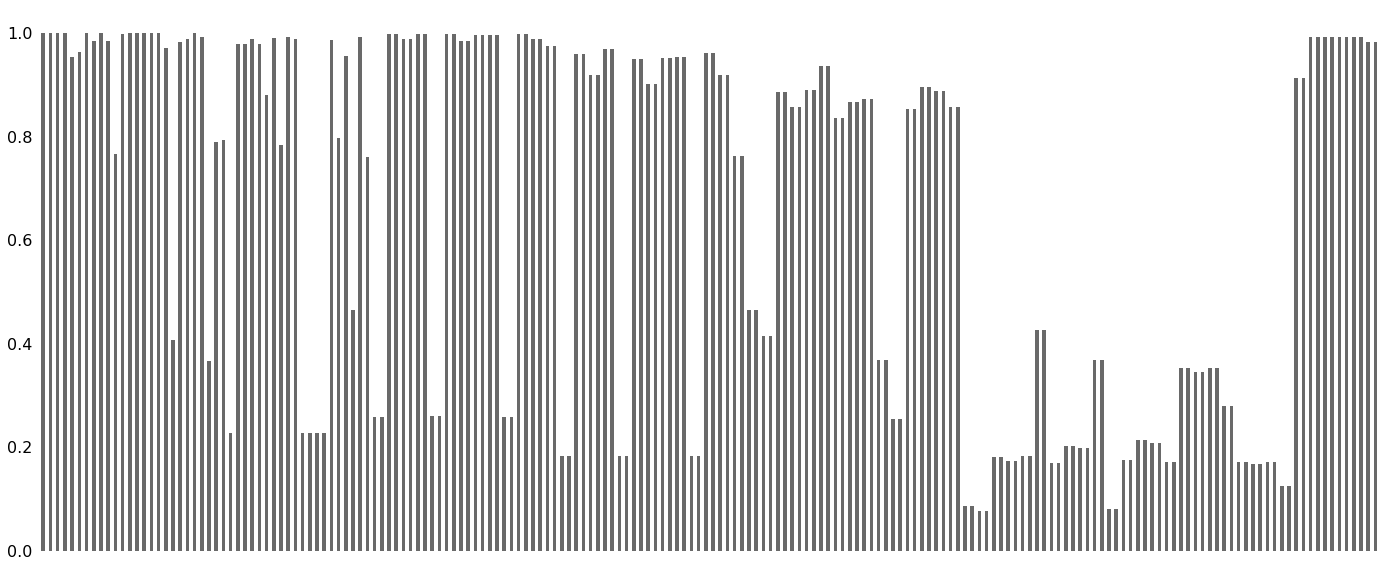

In [111]:
msno.bar(df)

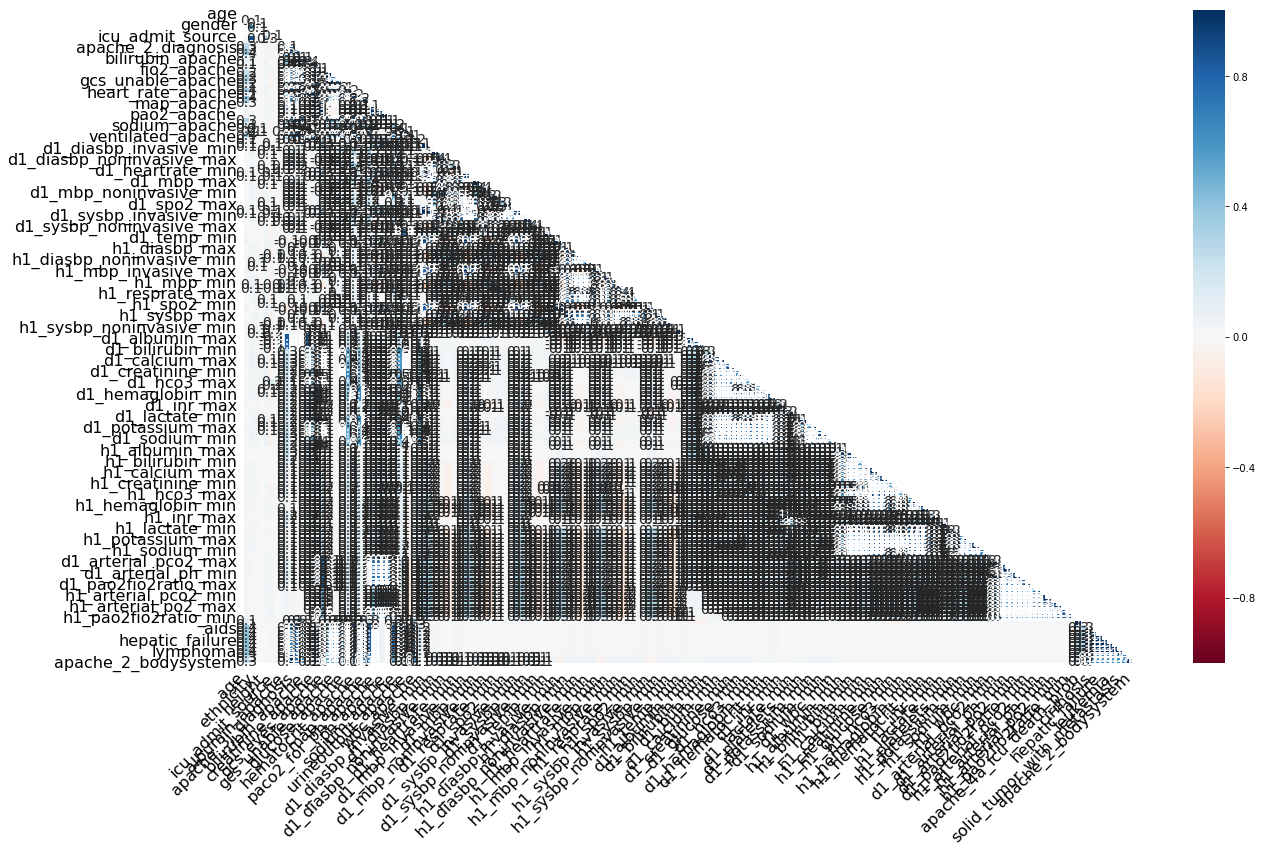

In [112]:
msno.heatmap(df)

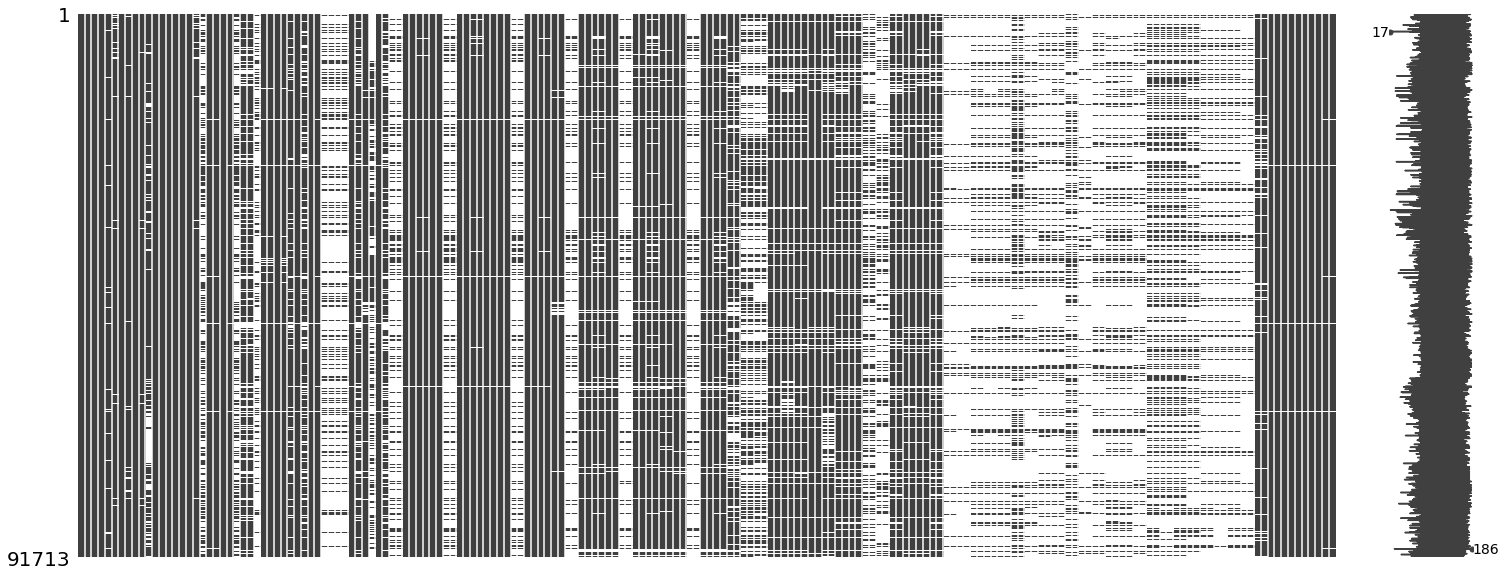

In [113]:
msno.matrix(df) 

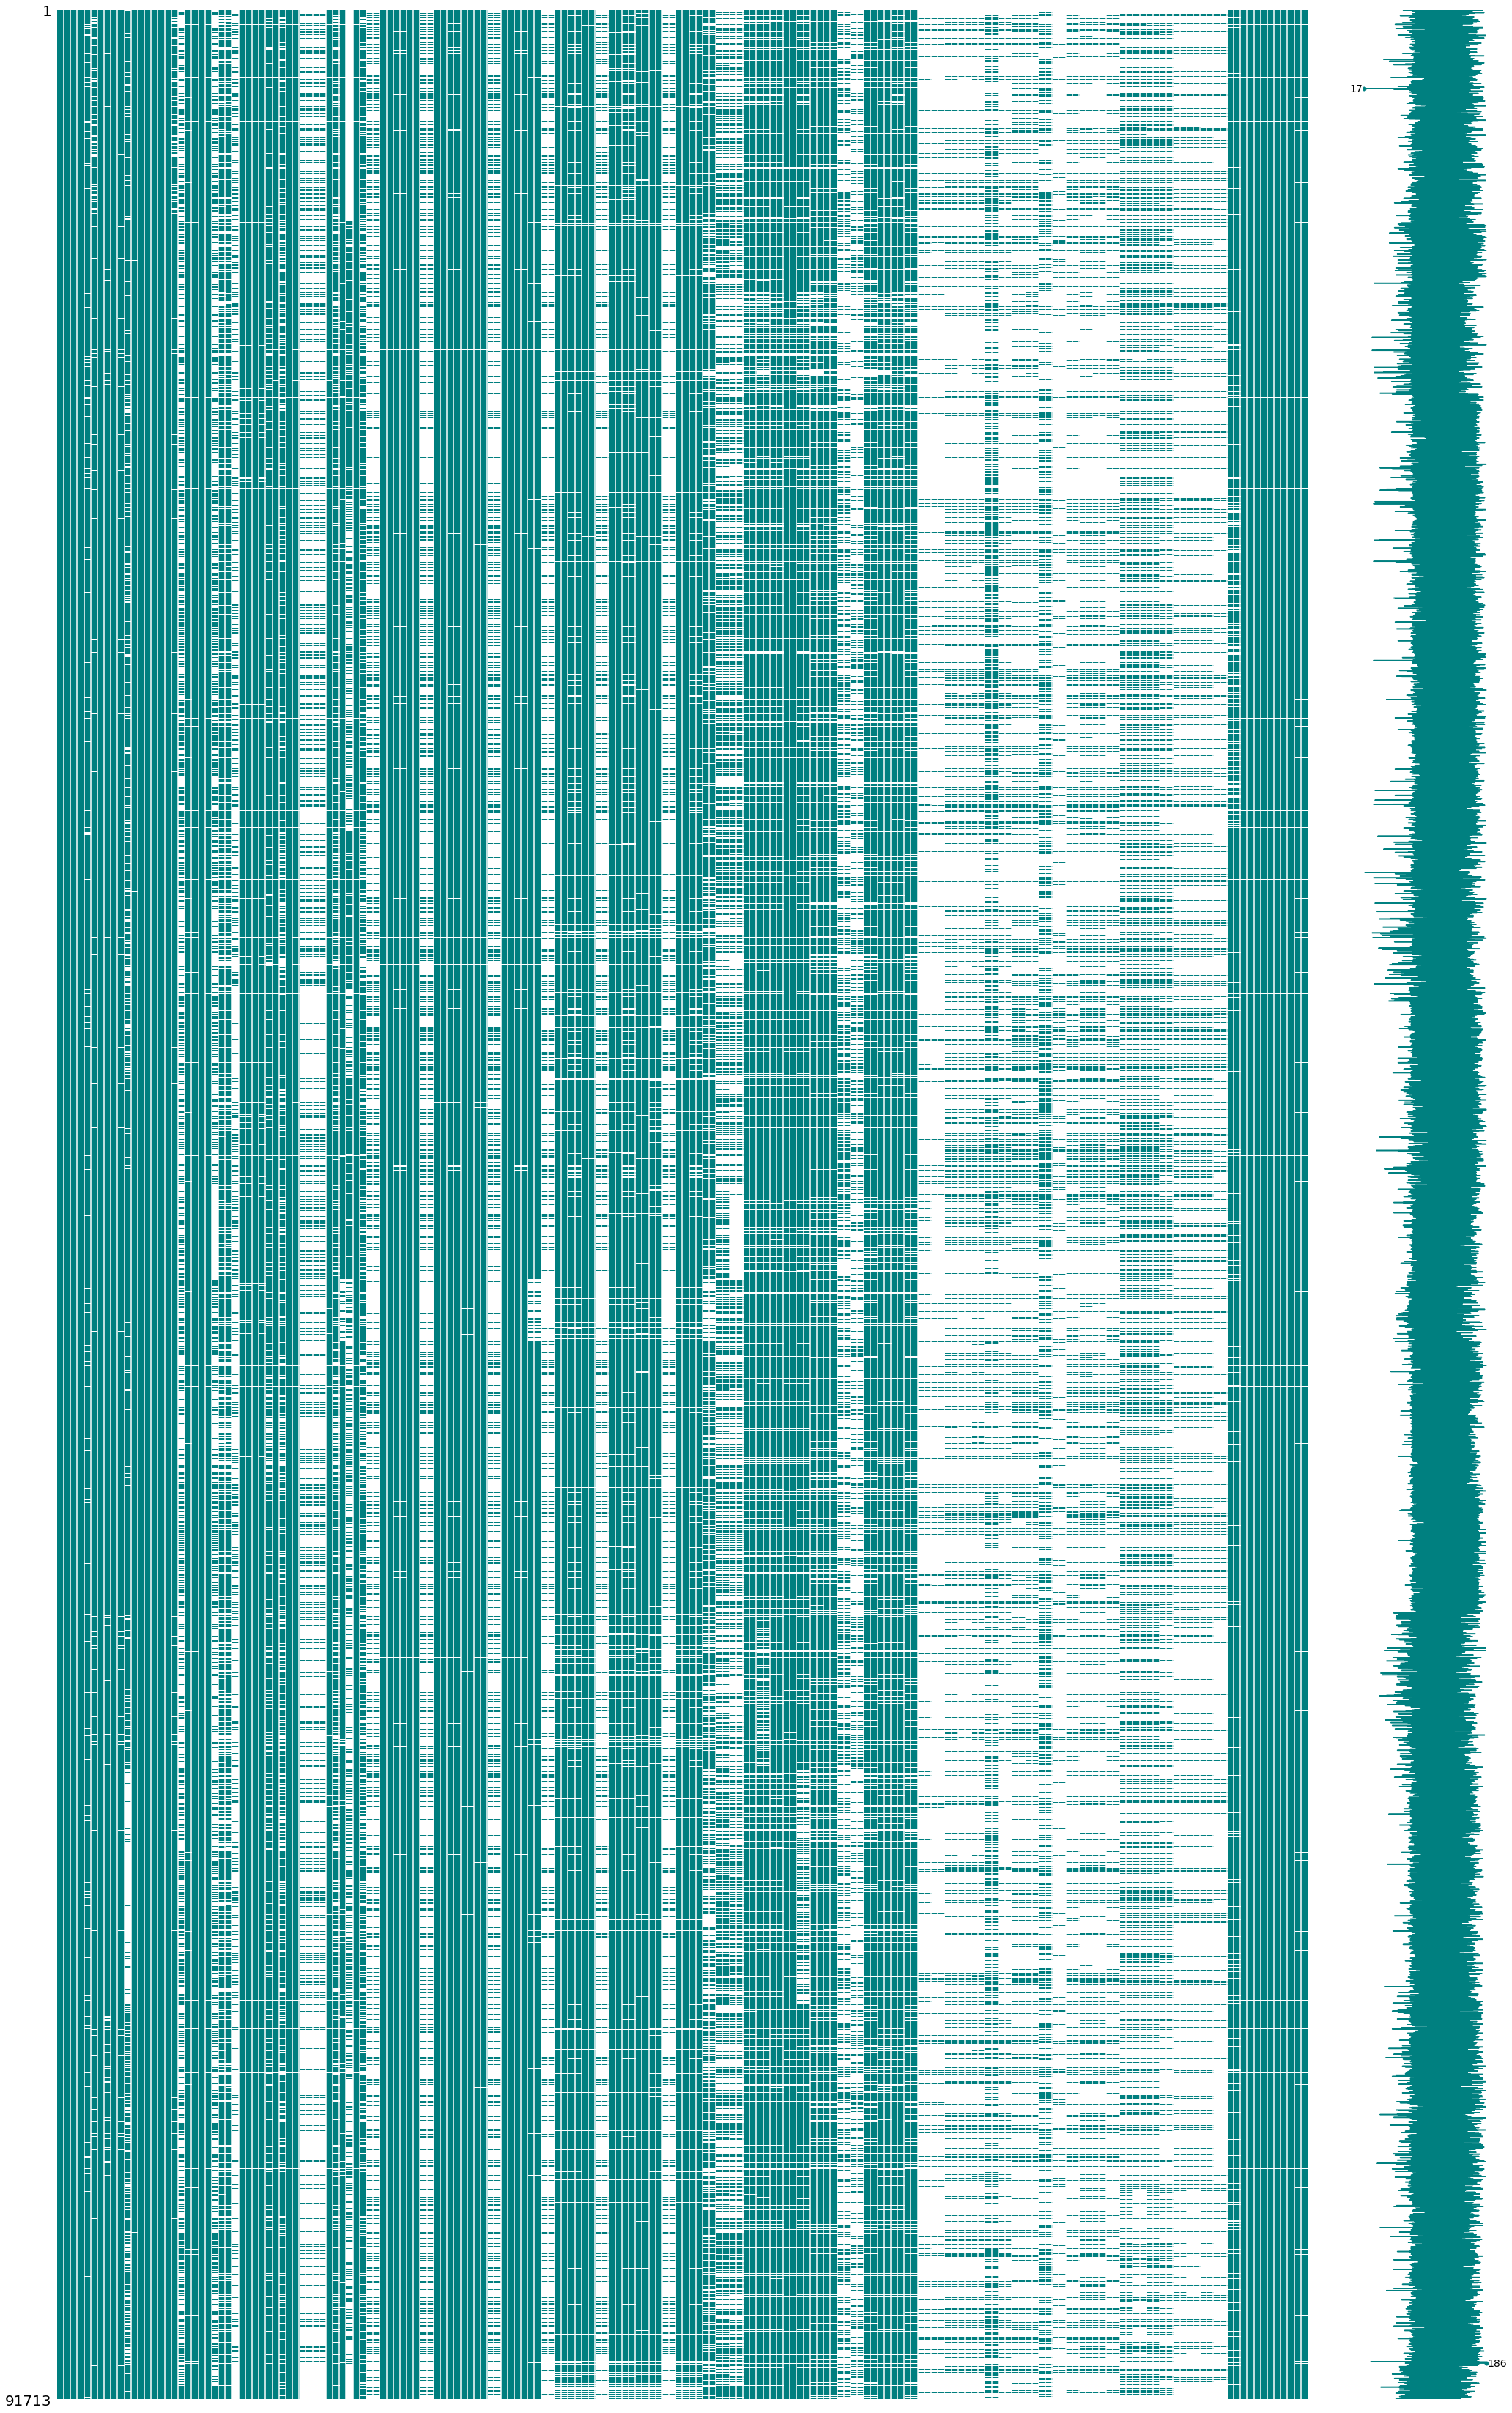

In [114]:
msno.matrix(df, figsize=(35, 60), width_ratios=(10, 1), color=(.0, 0.5, 0.5), fontsize=16)

In [132]:
df.hospital_id.nunique()

147

In [134]:
df.apache_3j_diagnosis.value_counts()

501.05     4481
107.01     4350
106.01     3923
403.01     3789
703.03     3106
104.01     2956
502.01     2842
1207.01    2763
102.01     2239
702.01     2064
212.01     1997
206.01     1883
1206.03    1848
305.02     1609
501.02     1475
111.01     1449
410.01     1415
407.01     1377
306.01     1254
501.06     1245
401.01     1243
901.03     1237
203.01     1177
108.01     1071
207.01     1037
1205.01    1000
501.01      992
305.01      945
601.01      896
704.01      813
211.09      726
501.04      665
109.09      633
409.02      632
1404.01     630
1212.03     541
1401.01     537
703.02      528
109.04      521
1505.01     465
208.01      463
1204.01     450
211.03      425
405.01      404
1302.02     403
105.02      389
0.25        387
109.02      387
109.10      376
209.01      376
802.01      374
212.02      371
201.01      363
311.01      349
109.03      335
1504.03     311
1405.02     301
109.14      299
204.01      291
701.02      280
109.16      265
408.02      262
109.01  

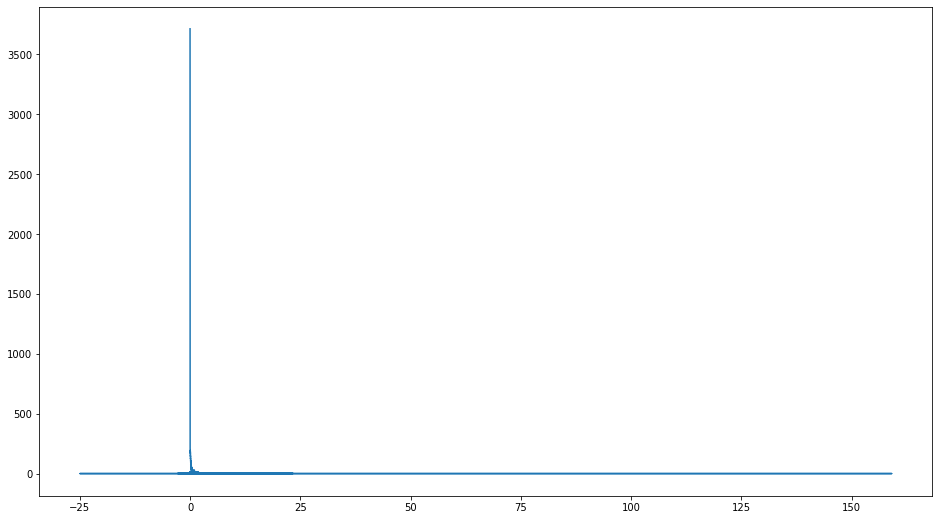

In [146]:
plt.figure(figsize=(16,9))
df.pre_icu_los_days.value_counts().plot()

In [172]:
tmp = df.groupby(['hospital_id'])['hospital_death'].sum()

In [174]:
tmp

hospital_id
2       78
3        1
4        0
5       43
6       12
8       21
9        1
10      84
13      62
14     115
15       4
16      23
17      28
18     141
19     394
20      14
21     291
23       1
24     108
26      86
27      61
29       9
30      24
31       7
32     130
33       9
34       5
35      45
36       6
37      40
38       0
39      93
40      27
43       0
44      13
46      16
47     104
49      37
50      12
51      32
53      10
54      52
55     115
57       4
60      45
62     101
63      10
64      33
66       0
68       2
69       8
70     237
71      25
72       0
74       1
76     208
77      21
78       4
79     123
80      15
81      25
83      62
84       1
85       0
87       3
88       5
89     108
90       9
91       2
92      53
93       0
94      17
95       0
98      60
99      47
100    293
101     52
102      4
103     46
104      3
105     43
107      9
109     77
111      0
112     89
113      5
116     85
117     12
118    306
119     2

In [155]:
cross = pd.crosstab(df.hospital_id, df.hospital_death)

In [156]:
cross

hospital_death     0    1
hospital_id              
2               1206   78
3                 15    1
4                  7    0
5                371   43
6                226   12
8                367   21
9                 42    1
10               656   84
13               967   62
14               677  115
15               156    4
16               249   23
17               265   28
18              1301  141
19              3531  394
20               105   14
21              2179  291
23                 6    1
24               789  108
26               650   86
27               778   61
29                41    9
30               491   24
31               180    7
32               772  130
33               314    9
34                45    5
35               897   45
36                47    6
37               694   40
38                10    0
39              1256   93
40               281   27
43               173    0
44               180   13
46               294   16
47               790  104
49               413   37
50               209   12
51                78   32
53               133   10
54               926   52
55              1794  115
57               170    4
60               477   45
62              1285  101
63               162   10
64               496   33
66                22    0
68                13    2
69               142    8
70              2517  237
71               143   25
72                15    0
74                12    1
76              1104  208
77               590   21
78                30    4
79              1387  123
80               259   15
81               555   25
83               758   62
84                11    1
85               133    0
87               108    3
88                56    5
89               934  108
90               148    9
91                44    2
92               395   53
93                 6    0
94               162   17
95                 6    0
98               482   60
99               365   47
100             1848  293
101              329   52
102               30    4
103              719   46
104              106    3
105              520   43
107              118    9
109              564   77
111              200    0
112             1233   89
113              103    5
116              996   85
117              224   12
118             4027  306
119              282   21
121              116    5
124                9    0
125              449   25
128              980   65
129               18    1
130                1    1
132              334   35
133              935   97
134              146    5
135              427   33
136              594   51
137              399   23
138             1158  102
139              638   35
140              189    6
142              175    1
145              404   88
146              661   68
147              787   90
149              303    8
150               31    5
151              200   13
155               73   19
157             1291  111
158              413   25
159              679   37
160              262   22
161             2558  234
166              675   35
167                9    1
168              255   16
169              259   21
171              883   61
174             1982  243
176             2239  344
177               71   10
179               97   11
180              121    8
181              404   55
182               70    7
183               16    1
184               72   12
185             1639  105
186              717   82
187              210   10
188             2847  248
189              566   45
192              496   20
194             1998  260
195              203   12
196             2502  228
197              116   11
198               27    2
199              509   37
200              332   35
202              286   21
204             1120  141

In [163]:
cross

hospital_death  hospital_id     0    1
0                         2  1206   78
1                         3    15    1
2                         4     7    0
3                         5   371   43
4                         6   226   12
5                         8   367   21
6                         9    42    1
7                        10   656   84
8                        13   967   62
9                        14   677  115
10                       15   156    4
11                       16   249   23
12                       17   265   28
13                       18  1301  141
14                       19  3531  394
15                       20   105   14
16                       21  2179  291
17                       23     6    1
18                       24   789  108
19                       26   650   86
20                       27   778   61
21                       29    41    9
22                       30   491   24
23                       31   180    7
24                       32   772  130
25                       33   314    9
26                       34    45    5
27                       35   897   45
28                       36    47    6
29                       37   694   40
30                       38    10    0
31                       39  1256   93
32                       40   281   27
33                       43   173    0
34                       44   180   13
35                       46   294   16
36                       47   790  104
37                       49   413   37
38                       50   209   12
39                       51    78   32
40                       53   133   10
41                       54   926   52
42                       55  1794  115
43                       57   170    4
44                       60   477   45
45                       62  1285  101
46                       63   162   10
47                       64   496   33
48                       66    22    0
49                       68    13    2
50                       69   142    8
51                       70  2517  237
52                       71   143   25
53                       72    15    0
54                       74    12    1
55                       76  1104  208
56                       77   590   21
57                       78    30    4
58                       79  1387  123
59                       80   259   15
60                       81   555   25
61                       83   758   62
62                       84    11    1
63                       85   133    0
64                       87   108    3
65                       88    56    5
66                       89   934  108
67                       90   148    9
68                       91    44    2
69                       92   395   53
70                       93     6    0
71                       94   162   17
72                       95     6    0
73                       98   482   60
74                       99   365   47
75                      100  1848  293
76                      101   329   52
77                      102    30    4
78                      103   719   46
79                      104   106    3
80                      105   520   43
81                      107   118    9
82                      109   564   77
83                      111   200    0
84                      112  1233   89
85                      113   103    5
86                      116   996   85
87                      117   224   12
88                      118  4027  306
89                      119   282   21
90                      121   116    5
91                      124     9    0
92                      125   449   25
93                      128   980   65
94                      129    18    1
95                      130     1    1
96                      132   334   35
97                      133   935   97
98                      134   146    5
99                      135   427   33
100                     136   594   51
101                   

In [ ]:
cross = pd.crosstab(df.hospital_id, df.hospital_death)
cross.reset_index(inplace=True)
sub_df1 = df.groupby(['RECL_LCC'])['COUNT'].sum()
sub_df2 = df.groupby(['RECL_PI'])['COUNT'].sum()

In [164]:
df.groupby(['hospital_id']).sum()

encounter_id  patient_id  hospital_death       age            bmi  elective_surgery     height   icu_id  pre_icu_los_days  readmission_status     weight  albumin_apache  apache_2_diagnosis  apache_3j_diagnosis  apache_post_operative  arf_apache  bilirubin_apache  bun_apache  creatinine_apache  fio2_apache  gcs_eyes_apache  gcs_motor_apache  gcs_unable_apache  gcs_verbal_apache  glucose_apache  heart_rate_apache  hematocrit_apache  intubated_apache  map_apache  paco2_apache  paco2_for_ph_apache  pao2_apache    ph_apache  resprate_apache  sodium_apache  temp_apache  urineoutput_apache  ventilated_apache  wbc_apache  d1_diasbp_invasive_max  d1_diasbp_invasive_min  d1_diasbp_max  d1_diasbp_min  d1_diasbp_noninvasive_max  d1_diasbp_noninvasive_min  d1_heartrate_max  d1_heartrate_min  d1_mbp_invasive_max  d1_mbp_invasive_min  d1_mbp_max  d1_mbp_min  d1_mbp_noninvasive_max  d1_mbp_noninvasive_min  d1_resprate_max  d1_resprate_min  d1_spo2_max  d1_spo2_min  \
hospital_id                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       
2                83875660    84155203              78   75846.0   36633.047013               165  217973.13  1124784        828.559028                   0  106527.55          1905.6            214674.0            680375.10                    196        14.0            568.50    30254.00           1603.280      208.530           4193.0            6810.0                0.0             4696.0        199037.1           131811.0            35950.1             265.0    100843.0       15847.0              15847.0      38706.6   2698.14054          28313.0       155621.0     46657.60        6.873817e+05              473.0    13769.50                 10992.0                  6195.0       119196.0        54986.0                   119107.0                    54946.0          138974.0           91154.0              15667.0               8278.0    135720.0     70983.0                135667.0                 70961.0          36584.0          15345.0     127693.0     113348.0   
3                 1157420     1203512               1     979.0     529.267468                 1    2557.00    14672         11.312500                   0    1537.40            28.4              2207.0              7584.28                      1         0.0              0.00      372.00             20.200        0.000             61.0              95.0                0.0               68.0          2137.0             1745.0              472.5               0.0      1464.0           0.0                  0.0          0.0      0.00000            599.0         2043.0       587.80        0.000000e+00                4.0      160.30                   223.0                    71.0         1593.0          743.0                     1593.0                      743.0            1918.0            1209.0                296.0                111.0      1879.0       992.0                  1879.0                   992.0            847.0            103.0       1591.0       1276.0   
4                  268246      415286               0     221.0     206.130211                 0 

In [170]:
cross = pd.crosstab(df.hospital_id, [df.hospital_death == 1])

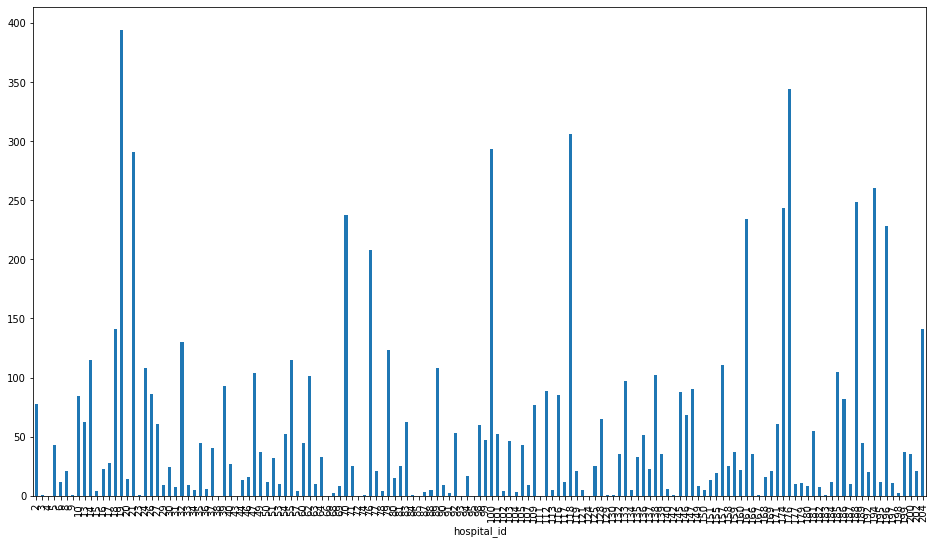

In [175]:
plt.figure(figsize=(16,9))
tmp.plot(kind="bar", figsize=(16,9))